<a href="https://colab.research.google.com/github/jeyasri-s2/SJSU297-AdvancedDL/blob/master/Assignment_1_Part_2/Assignment1_SemiSupervisedLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implement Semi-supervised learning in Pytorch (with MNIST Fashion Dataset)

In [ ]:
from __future__ import print_function
import pickle 
import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from scipy import ndimage
from scipy import misc

import tensorflow as tf
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# Hyperparameter declaration

In [ ]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

# Load dataset

In [ ]:
fashion_dataset =  torchvision.datasets.FashionMNIST('/data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))


fashion_val_dataset = torchvision.datasets.FashionMNIST('/data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

Extracting /data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /data/FashionMNIST/raw


Extracting /data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /data/FashionMNIST/raw


Extracting /data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /data/FashionMNIST/raw


Extracting /data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /data/FashionMNIST/raw
Processing...





/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


## Split labeled dataset into 20% and 80%, drop the labels of 80% of labeled data to convert to unlabeled data

In [ ]:
lengths = [int(len(fashion_dataset)*0.2), int(len(fashion_dataset)*0.8)]
labeled_subset, unlabeled_subset = random_split(fashion_dataset, lengths)



train_unlabeled_data = [(unlabeled_subset[i][0],-1) for i in range(len(unlabeled_subset))]
print(" Length of unlabeled data :",len(train_unlabeled_data))


 Length of unlabeled data : 48000


## Helper function

In [ ]:
def get_data_loaders(train_labeled_data, train_unlabeled_data, test_data, train_batch_size, val_batch_size):
    train_loader = DataLoader(train_labeled_data, batch_size=train_batch_size, shuffle=True)
    train_unlabeled_loader = DataLoader(train_unlabeled_data, batch_size=train_batch_size, shuffle=True)
    val_loader = DataLoader(test_data, batch_size=val_batch_size, shuffle=False,)



    return train_loader,train_unlabeled_loader, val_loader

In [ ]:
batch_size_train = 64
batch_size_test = 1000

train_labeled_loader,train_unlabeled_loader,val_loader =  get_data_loaders(labeled_subset, train_unlabeled_data,fashion_val_dataset, batch_size_train, batch_size_test)

## Example data for verification

In [ ]:
examples = enumerate(train_labeled_loader)
batch_idx, (example_data, example_targets) = next(examples)

## Define  convolutional network 

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [ ]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(val_loader.dataset) for i in range(n_epochs)]

## Training semi-supervised leraning with labeled data and adding unlabeled data at every cycle

In [ ]:
num_cycles = 15
# training
def train(epoch=5):
    network.train()
    
    #pre-training without unlabeled data train_labeled_loader,train_unlabeled_loader,val_loader
    if epoch > num_cycles:
        for batch_idx, (data, target) in enumerate(train_unlabeled_loader):
            network.eval()
            output = network(data)
            fake_target = (output.data.max(1)[1].view(-1)) # using pseudo label method and get pseudo labels
            network.train()
            #data.volatile = False
            optimizer.zero_grad()
            output = network(data)
            loss = F.nll_loss(output, fake_target)
            loss.backward()
            optimizer.step()
            if batch_idx % 10 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_unlabeled_loader.dataset),
                    100. * batch_idx / len(train_unlabeled_loader), loss.item()))

    avg_train_loss = 0
    for batch_idx, (data, target) in enumerate(train_labeled_loader):
        #data = conv_remap.remap(data, centers)
        
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_labeled_loader.dataset),
                100. * batch_idx / len(train_labeled_loader), loss.item()))
            avg_train_loss += loss.item()
            train_losses.append(loss.item())
            train_counter.append(
              (batch_idx*64) + ((epoch-1)*len(train_labeled_loader.dataset)))
     
    avg_train_loss = avg_train_loss / (len(train_labeled_loader) / 500)
    

In [ ]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in val_loader: #modified : test_loader
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(val_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(val_loader.dataset),
    100. * correct / len(val_loader.dataset)))

## Training network

In [ ]:
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/12000 (0%)]	Loss: 0.825727
Train Epoch: 1 [640/12000 (5%)]	Loss: 0.764427
Train Epoch: 1 [1280/12000 (11%)]	Loss: 0.945682
Train Epoch: 1 [1920/12000 (16%)]	Loss: 1.033784
Train Epoch: 1 [2560/12000 (21%)]	Loss: 0.754692
Train Epoch: 1 [3200/12000 (27%)]	Loss: 1.013000
Train Epoch: 1 [3840/12000 (32%)]	Loss: 0.903756
Train Epoch: 1 [4480/12000 (37%)]	Loss: 0.767281
Train Epoch: 1 [5120/12000 (43%)]	Loss: 0.867397
Train Epoch: 1 [5760/12000 (48%)]	Loss: 0.682717
Train Epoch: 1 [6400/12000 (53%)]	Loss: 0.695151
Train Epoch: 1 [7040/12000 (59%)]	Loss: 0.730815
Train Epoch: 1 [7680/12000 (64%)]	Loss: 0.780764
Train Epoch: 1 [8320/12000 (69%)]	Loss: 0.672859
Train Epoch: 1 [8960/12000 (74%)]	Loss: 0.803759
Train Epoch: 1 [9600/12000 (80%)]	Loss: 0.705056
Train Epoch: 1 [10240/12000 (85%)]	Loss: 0.807707
Train Epoch: 1 [10880/12000 (90%)]	Loss: 0.729744
Train Epoch: 1 [11520/12000 (96%)]	Loss: 0.835422


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6361, Accuracy: 7610/10000 (76%)

Train Epoch: 2 [0/12000 (0%)]	Loss: 0.620581
Train Epoch: 2 [640/12000 (5%)]	Loss: 0.802142
Train Epoch: 2 [1280/12000 (11%)]	Loss: 1.078898
Train Epoch: 2 [1920/12000 (16%)]	Loss: 0.699382
Train Epoch: 2 [2560/12000 (21%)]	Loss: 0.813011
Train Epoch: 2 [3200/12000 (27%)]	Loss: 0.611007
Train Epoch: 2 [3840/12000 (32%)]	Loss: 0.649724
Train Epoch: 2 [4480/12000 (37%)]	Loss: 0.754160
Train Epoch: 2 [5120/12000 (43%)]	Loss: 0.966111
Train Epoch: 2 [5760/12000 (48%)]	Loss: 0.723518
Train Epoch: 2 [6400/12000 (53%)]	Loss: 0.773037
Train Epoch: 2 [7040/12000 (59%)]	Loss: 0.783367
Train Epoch: 2 [7680/12000 (64%)]	Loss: 0.796552
Train Epoch: 2 [8320/12000 (69%)]	Loss: 1.066577
Train Epoch: 2 [8960/12000 (74%)]	Loss: 0.704010
Train Epoch: 2 [9600/12000 (80%)]	Loss: 0.630281
Train Epoch: 2 [10240/12000 (85%)]	Loss: 0.848509
Train Epoch: 2 [10880/12000 (90%)]	Loss: 0.723021
Train Epoch: 2 [11520/12000 (96%)]	Loss: 0.735210

Test set: Avg

In [ ]:
print(n_epochs)
print(len(test_losses))

len(test_counter)

3
3


3

## Loss plot

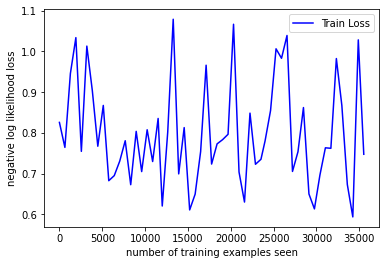

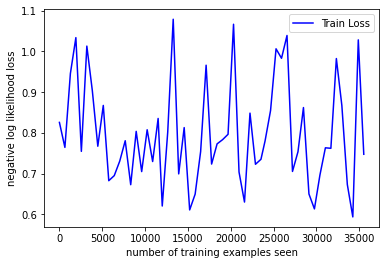

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
#plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [ ]:
with torch.no_grad():
  output = network(example_data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


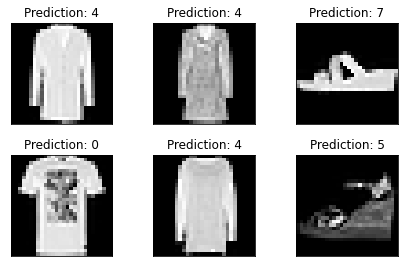

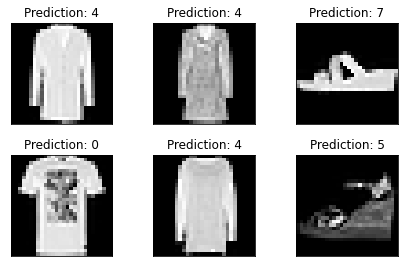

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

#Conclusion:


 Accuracy of the training data varies from 84% - 74% each iteration , test data improves to 77%